<a href="https://colab.research.google.com/github/cclljj/Google_colab_ipynb/blob/master/Kats_Time_Series_Forecasting_By_Facebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: 
* Kats - Time Series Forecasting By Facebook (https://medium.com/mlearning-ai/kats-time-series-forecasting-by-facebook-a2741794d814)

* How to use Facebook’s NeuralProphet and why it’s so powerful (https://towardsdatascience.com/how-to-use-facebooks-neuralprophet-and-why-it-s-so-powerful-136652d2da8b)

* Kats - One stop shop for time series analusis in Python (https://facebookresearch.github.io/Kats/)

In [ ]:
!pip install statsmodels==0.13.1
!pip install kats

!pip install ipython-autotime
%load_ext autotime

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
from kats.consts import TimeSeriesData
#from neuralprophet import NeuralProphet


## Configurations
HOURS = 24                    # number of predictions (units: hour)
DEVICE_ID = "B827EB70159C"    # AirBox device_id (https://pm25.lass-net.org/AirBox/)
## End of Configurations

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 10.2 s (started: 2022-02-10 14:06:19 +00:00)


In [ ]:
df = pd.read_csv('https://pm25.lass-net.org/data/history.php?format=CSV&device_id='+DEVICE_ID)


time: 4.38 s (started: 2022-02-10 14:06:29 +00:00)


In [ ]:
df['timestamp'] = pd.to_datetime(df.date + ' ' + df.time)

df2=pd.DataFrame()
df2['value'] = df[["timestamp", "s_s0L"]].resample('H', on='timestamp').s_s0L.mean()
df2 = df2.reset_index()
df2.columns = ["time","value"]

ts = TimeSeriesData(df2)
#ts.plot(["value"])

time: 35.4 ms (started: 2022-02-10 14:06:33 +00:00)


## **SARIMA model**

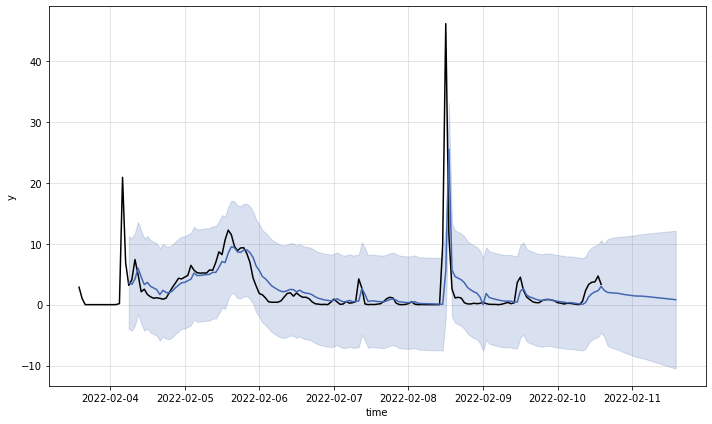

time: 2.87 s (started: 2022-02-10 14:06:34 +00:00)


In [ ]:
df['timestamp'] = pd.to_datetime(df.date + ' ' + df.time)

df2=pd.DataFrame()
df2['value'] = df[["timestamp", "s_d0"]].resample('H', on='timestamp').s_d0.mean()
df2 = df2.reset_index()
df2.columns = ["time","value"]

ts = TimeSeriesData(df2)

from kats.models.sarima import SARIMAModel, SARIMAParams
warnings.simplefilter(action='ignore')
# create SARIMA param class
params = SARIMAParams(
    p = 2, 
    d=1, 
    q=1, 
    trend = 'ct', 
    seasonal_order=(1,0,1,12)
    )
# initiate SARIMA model
m = SARIMAModel(data=ts, params=params)
# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=HOURS,
    include_history = True
    )

# make plot to visualize
m.plot()

## **Holt-Winters model** (not working yet, please ignore)

In [ ]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
warnings.simplefilter(action='ignore')
params = HoltWintersParams(
            trend="add",
            damped=False,
            seasonal="mul",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=ts, 
    params=params)
m.fit()
fcst = m.predict(
    steps=HOURS, 
    alpha = 0.1,
    include_history = True)
m.plot()

ValueError: ignored

time: 34.8 ms (started: 2022-02-10 14:06:36 +00:00)


## **Prophet model**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


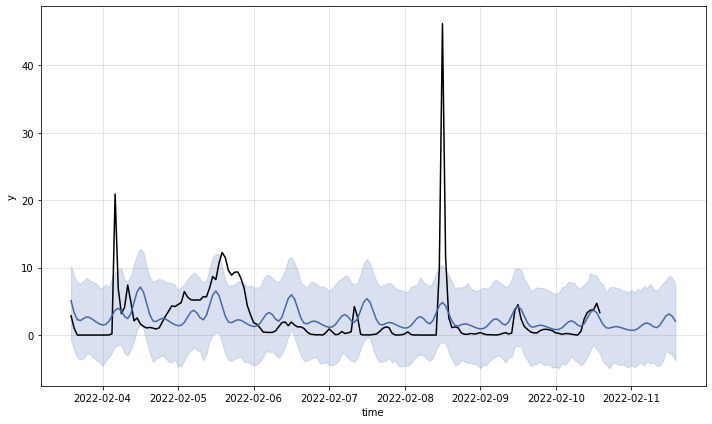

time: 4.7 s (started: 2022-02-10 14:07:02 +00:00)


In [ ]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next HOURS hours
fcst = m.predict(steps=HOURS, include_history = True)

# plot to visualize
m.plot()

## **Ensemble model**

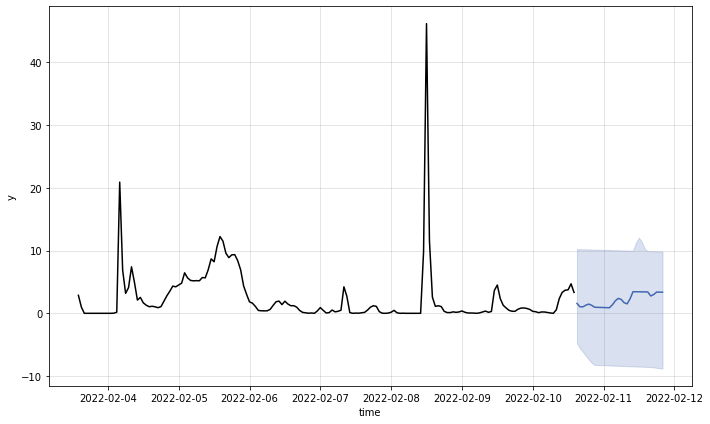

time: 5.95 s (started: 2022-02-10 14:07:06 +00:00)


In [ ]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima,
    holtwinters,
    linear_model,
    prophet,  # requires fbprophet be installed
    quadratic_model,
    sarima,
    theta,
)

# we need define params for each individual forecasting model in `EnsembleParams` class
# here we include 6 different models
model_params = EnsembleParams(
            [
#                BaseModelParams("arima", arima.ARIMAParams(p=1, d=1, q=1)),
                BaseModelParams(
                    "sarima",
                    sarima.SARIMAParams(
                        p=2,
                        d=1,
                        q=1,
                        trend="ct",
                        seasonal_order=(1, 0, 1, 12),
                        enforce_invertibility=False,
                        enforce_stationarity=False,
                    ),
                ),
                BaseModelParams("prophet", prophet.ProphetParams(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)),  # requires fbprophet be installed
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
                BaseModelParams("theta", theta.ThetaParams(m=12)),
            ]
        )

# create `KatsEnsembleParam` with detailed configurations 
KatsEnsembleParam = {
    "models": model_params,
    "aggregation": "median",
    "seasonality_length": 12,
    "decomposition_method": "multiplicative",
}

# create `KatsEnsemble` model
m = KatsEnsemble(
    data=ts, 
    params=KatsEnsembleParam
    )

# fit and predict
m.fit()

# predict for the next 30 steps
fcst = m.predict(steps=30)

# aggregate individual model results
m.aggregate()

# plot to visualize
m.plot()

## **Quadratic model**

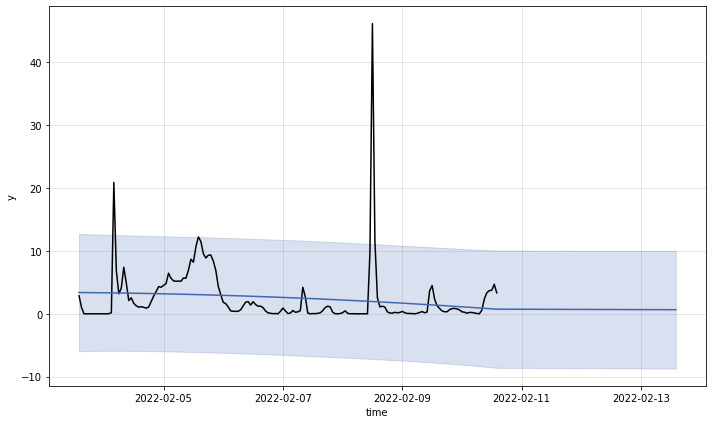

time: 331 ms (started: 2022-02-10 14:07:13 +00:00)


In [ ]:
# import the param and model classes for Quadratic model
from kats.models.quadratic_model import QuadraticModel, QuadraticModelParams

# create a model param instance
params = QuadraticModelParams(alpha=0.05)

# create a Quadratic model instance
m = QuadraticModel(ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next few steps
fcst = m.predict(steps=3, include_history = True)

# plot to visualize
m.plot()